### Helpers

In [1]:
# %load_ext autoreload
# %autoreload 2

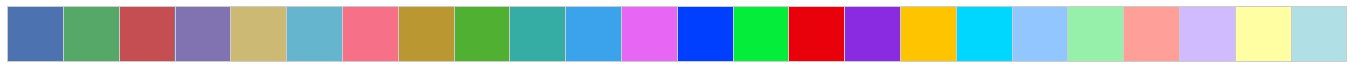

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
import warnings
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
    count_classes
)
# from pipeline import (
#     split_classes, count_classes, sample,
#     cross_validate, fit_predict_save, fit_save_model
# )
# from transformers.cosine import add_coses, to_degrees
from transformers.momentum import add_is_muon, add_is_muon_tight, add_probability_hit_detector
# from transformers.err import (
#     add_mse, add_normed_err, err_cols, add_errs, create_distr, get_dll_pdf, get_dll_cdf, ez,
#     add_velocity, vm_cols
# )

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [5]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols
global_feature_importance = None
train, train_foi = read_train(used_cols, 2000000)
display(train.shape, count_classes(train))

(2000000, 63)

(421218, 1578782)

Wall time: 6.99 s


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [4]:
import numpy as np
from common import xy_cols, xyz_cols, ex_cols, ey_cols, exy_cols, dx_cols, dy_cols, edxy_cols, z_cols, t_cols, mom_cols, N_STATIONS
from pipeline import split_classes

err_cols = ['ErrMSE', 'DLL']

nerr_x_cols = ['NErr_X[%i]' % i for i in range(N_STATIONS)]
nerr_y_cols = ['NErr_Y[%i]' % i for i in range(N_STATIONS)]
nerr_xy_cols = nerr_x_cols + nerr_y_cols

err_x_cols = ['Err_X[%i]' % i for i in range(N_STATIONS)]
err_y_cols = ['Err_Y[%i]' % i for i in range(N_STATIONS)]
err_z_cols = ['Err_Z[%i]' % i for i in range(N_STATIONS)]
err_xy_cols = err_x_cols + err_y_cols
err_xyz_cols = err_xy_cols + err_z_cols
ez = np.array([15270., 16470., 17670., 18870.])

def add_mse(data, features):
    dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
    D = np.nanmean(dxy**2, axis=1)
    
    data.loc[:, err_cols[0]] = D
    features += [err_cols[0]]
    return data

def add_normed_err(data, features):
    dxy = data.loc[:, xy_cols].values - data.loc[:, exy_cols].values
    normed_errors = dxy / np.sqrt(data.loc[:, edxy_cols].values)
    
    for i in range(4):
        data.loc[:, nerr_x_cols[i]] = normed_errors[:, i]
        data.loc[:, nerr_y_cols[i]] = normed_errors[:, i + 4]
    
    features += nerr_xy_cols
    return data

def add_errs(data, features):
    for err_col, e_col, col in zip (err_xy_cols, exy_cols, xy_cols):
        data.loc[:, err_col] = data[e_col].values - data[col].values
        
    for i in range(4):
        data.loc[:, err_z_cols[i]] = ez[i] - data[z_cols[i]].values
    
    features += err_xyz_cols

def create_distr(data):
    dts = [dt.loc[:, err_cols[0]] for dt in split_classes(data)]
    l, r = np.min(data[err_cols[0]]) - 1e-5, np.max(data[err_cols[0]]) + 1e-5
    bins = np.concatenate((
        np.arange(l, 1, .02),
        np.arange(1, 3, .04),
        np.arange(3, 10, .1),
        np.arange(10, 16, .4),
        np.arange(16, 34, 1.),
        np.arange(34, 66, 2),
        np.arange(66, 120, 5.),
        np.linspace(120, r, 3),
    ))
    pdfs = []
    
    for i in range(2):
        pdf, _ = np.histogram(dts[i], bins=bins)
        pdfs.append(pdf)
    
    cdfs = [np.cumsum(pdf) for pdf in pdfs]
    
    return cdfs, pdfs, bins

# выбираем опцию, как считать DLL - либо на основе pdf, либо на основе cdf
def get_dll_pdf(x, pdfs, cdfs, bins):
    def get_probs_pdf(pdf, x):
        indices = np.digitize(x, bins) - 1
        wbin = (bins[indices + 1] - bins[indices]) / (np.max(bins) - np.min(bins))
        prob = pdf[indices] / pdf.sum()
        return prob #* wbin

    probs = [get_probs_pdf(pdf, x) for pdf in pdfs]
    DLL = np.log(probs[1]) - np.log(probs[0])
    return DLL

def get_dll_cdf(x, pdfs, cdfs, bins):
    def get_probs_cdf(cdf, x):
        indices = np.digitize(x, bins) - 1
        wbin = (bins[indices + 1] - bins[0]) / (np.max(bins) - np.min(bins))
        prob = cdf[indices] / cdf[-1]
        return prob * wbin
    probs = [get_probs_cdf(cdf, x) for cdf in cdfs]
    DLL = np.log(probs[1]) - np.log(probs[0])
    return DLL

def add_dll(data, features):
    data[err_cols[1]] = get_dll_pdf(data.loc[:, err_cols[0]], pdfs, cdfs, bins)
    features += err_cols[1:2]
    return data

vm_cols = ['V', 'VT', 'M', 'MT']

def add_velocity(data, features):
    def get_layer_coords(data, cols, i):
        return data[[cols[i], cols[i+4], cols[i+8]]].values
    def get_elayer_coords(data, i):
        exy = data.loc[:, [ex_cols[i], ey_cols[i]]].values
        ez_ = np.tile(ez[i], exy.shape[0]).reshape((-1, 1))
        return np.hstack((exy, ez_))
    def dot(x, y):
        return np.sum(x * y, axis=1, dtype=np.float32)
    def norm(x):
        return np.sqrt(dot(x, x))
    def get_zero_point(data):
        layers = [get_elayer_coords(data, i) for i in range(2)]
        r = layers[1] - layers[0]
        r = r / norm(r)[:, np.newaxis]
        p = get_elayer_coords(data, 0)
        alpha = - p[:, 2] / r[:, 2]
        
        xs = p[:, 0] + alpha * r[:, 0]
        ys = p[:, 1] + alpha * r[:, 1]
        zs = np.tile(0, len(xs))
        return np.vstack((xs, ys, zs)).T
    
    # radius-vector r_i = p_i - p_0: S x N x 3; 
    r = np.array([get_layer_coords(data, xyz_cols, i) for i in range(4)]) - get_zero_point(data)
    
    # time: S x N
    t = data.loc[:, t_cols].values.T
    
    # average velocity avg(r / t): N x 3    
    v_avg = np.nanmean(r / t[:, :, np.newaxis], axis=0)
    # average speed |v|: N
    speed = norm(v_avg)
    # transverse speed |v_xy|: N
    speed_tr = norm(v_avg * np.array([1., 1., 0.]))
    
    # momentum: N
    p = data.loc[:, mom_cols[0]].values
    # transverse momentum: N
    p_tr = data.loc[:, mom_cols[1]].values
    
    # mass: N
    m = p / speed
    # transverse mass: N
    m_tr = p_tr / speed_tr

    results = [speed, speed_tr, m, m_tr]
    for col, res in zip(vm_cols, results):
        data.loc[:, col] = res
    features += vm_cols
    return data

In [7]:
# готовим данные для распределения DLL

# либо загружаем уже готовое
dll_filename = 'data/dll.pkl'
# dll_train = pd.read_pickle(dll_filename)
# display(dll_train.columns)

# либо считаем заново
# dll_train, _ = read_train(xy_cols + dx_cols + dy_cols + exy_cols, 10000000)
# dll_train = add_mse(train, [])

# опционально пересчитываем MatchedHits и заменяем ими координаты треков в dll_train, чтобы считать распределение на пересчитанных треках
# dll_train = replace_hits(dll_train, [])

# save DLL
# display(dll_train.columns)
# dll_train.to_pickle(dll_filename)

In [5]:
# если распределение для DLL уже есть сохраненное, то загружаем
cdfs, pdfs, bins = np.load('data/train_cdfs.pkl.npy'), np.load('data/train_pdfs.pkl.npy'), np.load('data/train_bins.pkl.npy')

# либо считаем на основе загруженного dll_train
# cdfs, pdfs, bins = create_distr(dll_train)
# np.save('data/train_cdfs.pkl.npy', cdfs)
# np.save('data/train_pdfs.pkl.npy', pdfs)
# np.save('data/train_bins.pkl.npy', bins)

In [6]:
import numpy as np
from common import x_cols, y_cols, z_cols, ex_cols, ey_cols

da_cols = ['DAngle[%d]' % i for i in range(1, 4)]

def add_coses(data, features):
    def get_layer_coords(data, i):
        return data[[x_cols[i], y_cols[i], z_cols[i]]].values
  
    def dot(x, y):
        return np.sum(x * y, axis=1, dtype=np.float32)
    
    def norm(x):
        return np.sqrt(dot(x, x))

    def get_cosine_dist(L1, L2, L1_norm, L2_norm):
        cosines = dot(L1, L2) / L1_norm / L2_norm
        return np.clip(cosines, -1., 1.)
    
    layers = np.array([get_layer_coords(data, i) for i in range(4)])
    layers[1:] -= layers[:3]
    layers[0] = get_zero_point(data)
    
    for i in range(3):
        cur_layer = layers[i]
        next_layer = layers[i+1]
        nan_mask = np.isnan(next_layer[:, 0])
        next_layer[nan_mask, :] = cur_layer[nan_mask, :]
        
        cosines = get_cosine_dist(cur_layer, next_layer, norm(cur_layer), norm(next_layer))
        degrees = to_degrees(cosines)
        cosines[nan_mask] = np.NaN
        degrees[nan_mask] = np.NaN
        data[da_cols[i]] = degrees
        
    features += da_cols
    return data

def to_degrees(cosine):
    return np.arccos(cosine) / np.pi * 180.

def _to_degrees(cosines):
    angles = cosines.copy()
    isn_mask = ~np.isnan(cosines)
    angles[isn_mask] = np.arccos(cosines[isn_mask]) / np.pi * 180.
    return angles

def get_zero_point(data):
    layers = [data[[ex_cols[i], ey_cols[i], z_cols[i]]].values for i in range(2)]
    d = layers[1] - layers[0]
    return d

In [8]:
def add_matched_hits_coses(data, features):
    def get_layer_coords(data, i):
        return data[['_X[%d]'%i, '_Y[%d]'%i, '_Z[%d]'%i]].values
    def dot(x, y):
        return np.sum(x * y, axis=1, dtype=np.float32)
    
    def norm(x):
        return np.sqrt(dot(x, x))

    def get_cosine_dist(L1, L2, L1_norm, L2_norm):
        cosines = dot(L1, L2) / L1_norm / L2_norm
        return np.clip(cosines, -1., 1.)
    def get_zero_point(data):
        layers = [data[[ex_cols[i], ey_cols[i], z_cols[i]]].values for i in range(2)]
        d = layers[1] - layers[0]
        return d
    
    layers = np.array([get_layer_coords(data, i) for i in range(4)])
    layers[1:] -= layers[:3]
    layers[0] = get_zero_point(data)
    cols = ['_DAngle[%d]'%i for i in range(1, 4)]
    
    for i in range(3):
        cur_layer = layers[i]
        next_layer = layers[i+1]
        nan_mask = np.isnan(next_layer[:, 0])
        next_layer[nan_mask, :] = cur_layer[nan_mask, :]
        
        cosines = get_cosine_dist(cur_layer, next_layer, norm(cur_layer), norm(next_layer))
        degrees = to_degrees(cosines)
        cosines[nan_mask] = np.NaN
        degrees[nan_mask] = np.NaN
        data[cols[i]] = degrees
        
    features += cols
    return data
def add_matched_hits(data, features):
    global_matched_hits = global_matched_hits_train if train_cols[0] in data.columns else global_matched_hits_test
    for col in global_matched_hits.columns:
        data.loc[:, col] = global_matched_hits.loc[data.index.values, col].values
    features += list(global_matched_hits.columns)
    return data

def add_matched_hits_online(data, features):
    data_foi = train_foi if train_cols[0] in data.columns else test_foi
    matched_hits = match_hits_batched(data, data_foi)
    for col in matched_hits.columns:
        data.loc[:, col] = matched_hits.loc[data.index.values, col].values
    features += list(matched_hits.columns)
    return data

In [10]:
test, test_foi = read_pvt_test(SIMPLE_FEATURE_COLS)# + ARR_FEATURE_COLS)

In [32]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import model_selection as mdsel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import scoring
from common import train_cols

def normalize(predictions, theta):
    predictions -= theta
    left = predictions[predictions < 0]
    right = predictions[predictions > 0]
    left /= -np.min(left)
    right /= np.max(right)
    predictions += 1.
    predictions /= 2.
    
def predict(model, test, test_foi):
    model_name, th = model
    model_filename = 'models/'+model_name
    
    
    transformer, estimator = DataTransformer(), xgb.XGBClassifier.load_model(model_filename)
    test_value = transformer.transform(test)
    predictions = estimator.predict_proba(test_value)[:, 1]
    normalize(predictions)
    return predictions

def fit_predict_save(train, test, filename, n_estimators, transformer_cls):
    fitted_state = fit(train, n_estimators, transformer_cls)
    predictions = predict(fitted_state, test)
    
models = [
    ('09_err_xyz_100', 0.19043), #                                 | 19213590 | 7315.29 |
    ('09_vm_100', 0.19043), #                                     | 19236776 | 7324.46 |
    ('10_wo_time_constraints_mean_100', 0.103246), #              | 19247316 | 7287.91 |
    ('11_1m_1000', 0.0867), #                                     | 19249842 | 7385.34 |
    ('12_baseline_2m_400.xgb', 0.19043), #                            | 19263823 | 7387.86 |
]

predictions = [predict(model, test, test_foi) for model in models[-1:]]
predictions = sum(predictions) / len(predictions)
pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv('14_final.csv', index_label='id')

In [7]:
%%time
from sklearn.base import TransformerMixin

def filter_unimportant_features(features):
    if global_feature_importance is None:
        return features
    fscore = global_feature_importance
    return [col for col in features if col not in fscore.index or fscore.loc[col, 'score'] > 0.00]
    return features

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        features = [] + mom_cols + hit_type_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + dxyz_cols
        features = filter_unimportant_features(features)
        self.origin_features = features.copy()

        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
        add_dll(data, features)
        add_errs(data, features)
        add_velocity(data, features)
        
        if not features:
            raise('no features')
    
        features = filter_unimportant_features(features)
        self.new_features = features[len(self.origin_features):]
        self.features = self.origin_features + self.new_features
        return data[features].values

# df_scores, feature_importance = cross_validate(train, n_estimators=10, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
# display(df_scores.describe())

Wall time: 0 ns


### Test theory

In [73]:
%%time
global_feature_importance = None
df_scores, feature_importance = cross_validate(train, n_estimators=120, n_splits=5, n_rows=200000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.788060,0.780809,0.881382,0.828052,0.831894,0.737224,0.086723
std,0.002346,0.001948,0.002166,0.001886,0.002957,0.016519,0.002334
min,0.785700,0.778269,0.878670,0.826379,0.828253,0.716133,0.083700
25%,0.786800,0.780454,0.880829,0.826765,0.830061,0.734441,0.085177
50%,0.787750,0.780651,0.881347,0.827838,0.831992,0.734969,0.086766
75%,0.788150,0.780932,0.881347,0.828107,0.833185,0.738197,0.088889
max,0.791900,0.783736,0.884715,0.831170,0.835979,0.762381,0.089084


Wall time: 2min 13s


In [45]:
%%time
global_feature_importance = None
df_scores, feature_importance = cross_validate(train, n_estimators=120, n_splits=1, n_rows=400000, transformer_cls=DataTransformer)
display(df_scores.describe())

# global_feature_importance = feature_importance.copy()
# display(sum(global_feature_importance.score > .01))

,acc,prec,rec,f1,roc_auc,scr,th
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
mean,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043
25%,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043
50%,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043
75%,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043
max,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043


31

Wall time: 1min 52s


In [38]:
global_feature_importance = feature_importance.copy()
sum(global_feature_importance.score > .01)

29

In [39]:
display(global_feature_importance)

,score
ErrMSE,0.116029
PT,0.076555
NShared,0.046651
DAngle[1],0.044258
DAngle[2],0.040670
P,0.039474
ncl[2],0.039474
MT,0.037081
NErr_Y[3],0.032297
NErr_X[0],0.028708


### Get result

In [46]:
test, test_foi = read_pub_test(used_cols)
# global_matched_hits_test = match_hits_batched(test, test_foi)

In [47]:
%%time
_t = global_feature_importance
# global_feature_importance = None
fit_predict_save(sample(train, 2000000), test, "out/12_baseline_2m_400.csv", n_estimators=400, transformer_cls=DataTransformer)
global_feature_importance = _t

Wall time: 1h 51s


In [107]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_120.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 6min 57s


In [108]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_200.csv", n_estimators=200, transformer_cls=DataTransformer)

Wall time: 11min 39s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [139]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

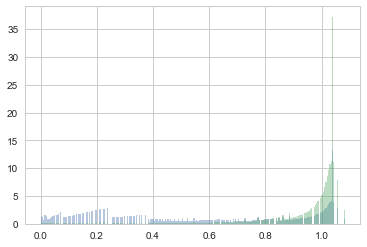

In [133]:
def plot_dll(data):
    DLL = get_dll_cdf(data, pdfs, cdfs, bins)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        _ = sns.distplot(DLL, bins=len(bins), kde=False, norm_hist=True)

dts = [dt.loc[:, err_cols[0]] for dt in split_classes(dll_train)]
plot_dll(dts[0].values)
plot_dll(dts[1].values)
# plot_dll(dll_train.loc[:, err_cols[0]].values)

In [110]:
nrows = 1000000
train, train_foi = read_train(foi_ts_cols, nrows)

ts = train_foi[foi_ts_cols[0]].values
dts = train_foi[foi_ts_cols[1]].values

DescribeResult(nobs=8637411, minmax=(1.0, 15.0), mean=6.558298, variance=11.261726, skewness=0.4544934630393982, kurtosis=-0.38207915523810065)
DescribeResult(nobs=8637411, minmax=(-14.0, 15.0), mean=2.0806417, variance=20.990376, skewness=0.5840174555778503, kurtosis=0.9575571200203767)


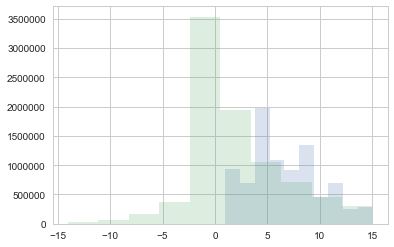

In [111]:
plt.hist(ts, alpha=0.2)
plt.hist(dts, alpha=0.2)

print(sts.describe(ts))
print(sts.describe(dts))

In [129]:
print(np.quantile(dts, (0.08, 0.8)))

[-2.  6.]
